<a href="https://colab.research.google.com/github/ludwigenvall/churn-prediction-dl/blob/main/Churn_Projekt_Rapport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Förutsägelse av Kundbortfall med Simulerade Kundsekvenser och LSTM

## Introduktion

Kundbortfall, även kallat churn, är när en kund avslutar sitt avtal eller prenumeration hos ett företag. Det är ett stort problem för många abonnemangsbaserade verksamheter eftersom det är mer kostsamt att värva en ny kund jämfört med att behålla en befintlig. Att kunna prediktera churn i förväg ger företag möjligheten att agera proaktivt med riktade åtgärder för att öka kundlojalitet.

Traditionella churnmodeller bygger ofta på statiska egenskaper som kundens ålder, avtalstyp eller tidigare historik. Det gör att de missar hur beteendet faktiskt förändras över tid, något som ofta är avgörande inför ett bortfall.  I I det här projektet undersöks en alternativ metodik, där kundens dagliga beteende simuleras över en period av 30 dagar. Genom att kombinera en bayesiansk generativ modell (för simulering) med Long Short-Term Memory (LSTM) neurala nätverk för sekventiell klassificering skapas en kraftfull metod för churnprediktion.

Projektets mål är att svara på frågeställningen:

> Kan en LSTM-modell, tränad på syntetiskt genererade beteende sekvenser, identifiera kundbortfall med hög noggrannhet?

## Metod

### Data & Simulering med bayesiansk generativ modell

Som utgångspunkt användes *Telco Customer Churn*-datasetet från Kaggle, där varje kund är märkt som churner eller icke-churner. Själva beteendet, alltså inloggningar, supportkontakt och dataanvändning, simulerades istället för att använda verkliga loggar. Detta möjliggör full kontroll över datans egenskaper och eliminerar behovet av att hantera personuppgifter.




#### Modellstruktur

Tre sekventiella variabler simulerades över 30 dagar per kund:

- `logins_seq`: dagliga antal inloggningar, simulerade med en Poissonfördelning.
- `support_seq`: binär indikator för supportkontakt, simulerad med en Binomialfördelning.
- `data_seq`: daglig dataanvändning i GB, simulerad med en Gammafördelning.

Beroende på kundens churn-status användes olika parametrar för varje fördelning. Dessa parametrar skattades utifrån observerade dummyvärden (genererade med olika parametrar för churners vs. icke-churners). Modellen specificerades i PyMC på följande sätt:

- För inloggningar skattades två olika `lambda`-parametrar med exponentialfördelningar, en för churners och en för icke-churners.
- För supportkontakt skattades sannolikheterna `p_churn` och `p_nochurn` från varsin betafördelning.
- För dataanvändning skattades `shape` och `scale` från gammafördelningar, också separata för churners och icke-churners.

Posteriorfördelningarna för samtliga parametrar skattades med hjälp av MCMC-sampling (`pm.sample()`).

Totalt simulerades 7 035 kundsekvenser. Datan transformerades till 3D-tensorer av formen (n_samples, 30, 3) och delades in i 80% träningsdata och 20% testdata.


#### Exempel på PyMC-modell (förenklad)



Modellen skattade sannolika parametrar givet kundens churnstatus. Dessa användes sedan som input till random.poisson(), random.binomial() och random.gamma() från numpy, för att generera sekvenserna som användes som indata till LSTM-modellerna.

In [ ]:
with pm.Model() as model:
    lambda_churn = pm.Exponential("lambda_churn", lam=1.05)
    lambda_nochurn = pm.Exponential("lambda_nochurn", lam=1.0)
    lambda_logins = pm.math.switch(churn_flag, lambda_churn, lambda_nochurn)
    logins_obs = pm.Poisson("logins_obs", mu=lambda_logins, observed=df['logins'])

    p_churn = pm.Beta("p_churn", alpha=2, beta=44)
    p_nochurn = pm.Beta("p_nochurn", alpha=2, beta=48)
    p_support = pm.math.switch(churn_flag, p_churn, p_nochurn)
    support_obs = pm.Binomial("support_obs", n=30, p=p_support, observed=df['support_contacts'])

### Visualisering av simulerat beteende

Nedan följer exempel på de simulerade kundsekvenserna för att ge en känsla för datans struktur.


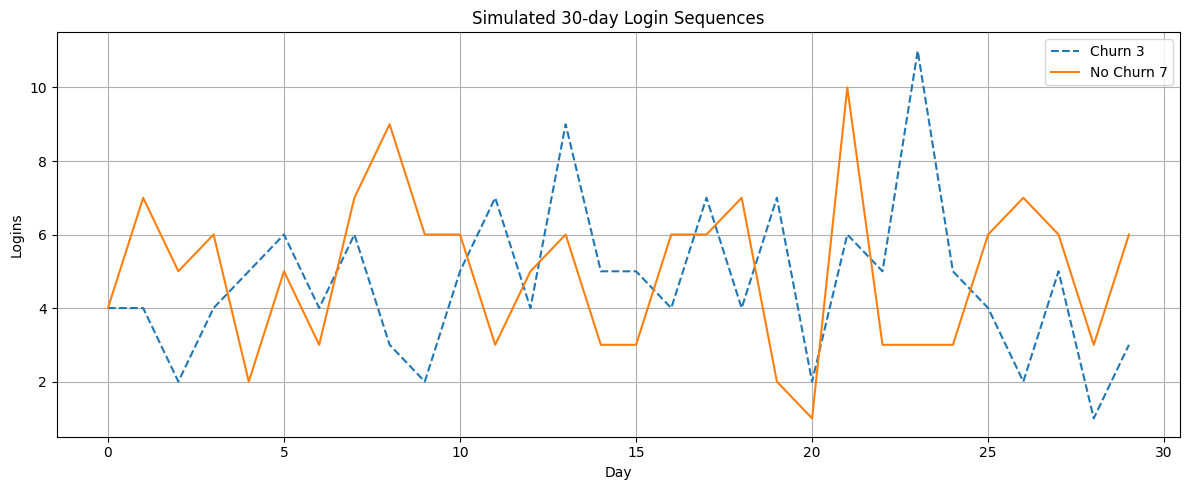

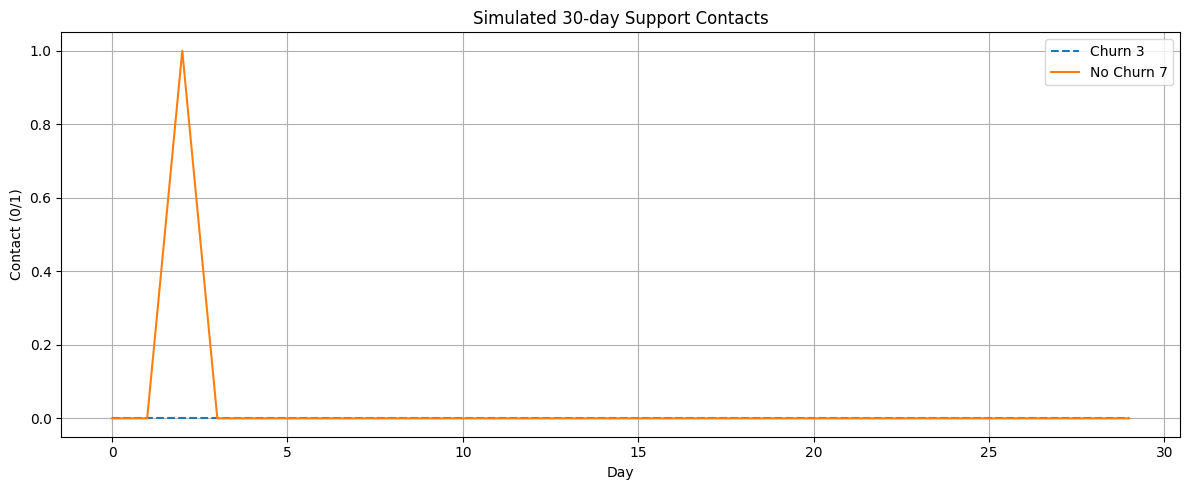


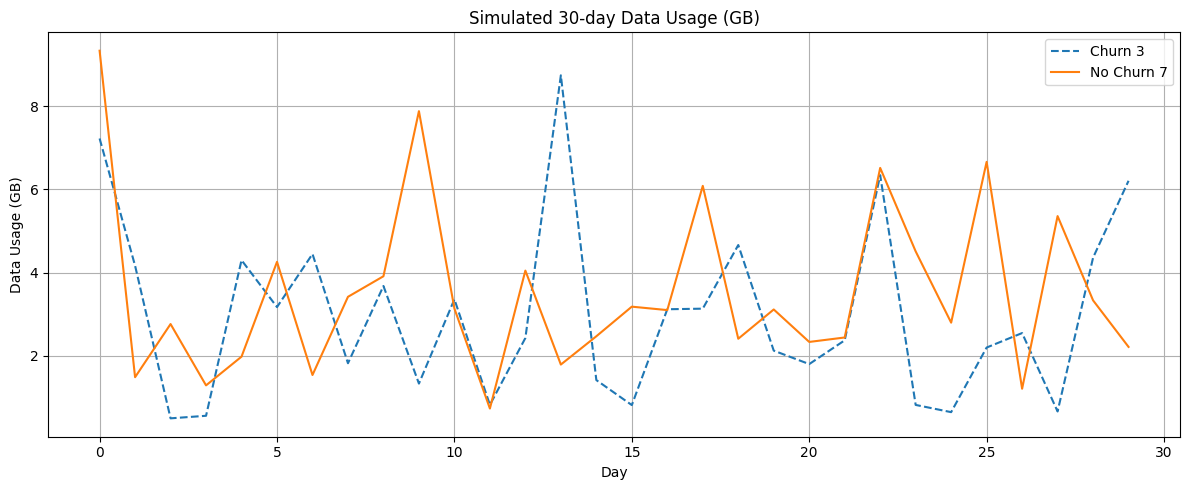



### Modellering med LSTM

För att kunna förutsäga churn baserat på de simulerade kundsekvenserna användes Long Short-Term Memory (LSTM) neurala nätverk. LSTM är särskilt lämpad för sekventiell data eftersom den kan lära sig beroenden över tid, något som traditionella neurala nätverk har svårt med.


#### Dataförberedelse

Sekvenserna (inloggningar, supportkontakt, dataanvändning) hade ursprungligen formen av listor lagrade som text. Dessa konverterades först tillbaka till riktiga listor, och därefter till numpy-arrays i formatet `(n_samples, 30, 3)`, där varje sekvens bestod av 30 dagar och 3 variabler.

Churn-variabeln kodades binärt (Yes = 1, No = 0) och datan delades upp i träning/test med train_test_split().


#### Basmodell: enkel LSTM
Den enklaste modellen bestod av ett LSTM-lager med 64 noder följt av 30% dropout och två dense-lager

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(30, 3), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Djupare modell
Här användes två LSTM-lager (64 respektive 32 noder) med dropout (30% respektive 20%) mellan dem, följt av dense-lager

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 3)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Bidirectional modell
Nästa modell som undersöktes är en bidirectional modell, som bestod av ett bidirektionellt LSTM-lager med 64 noder, följt av 30% dropout, sedan ett LSTM lager med 32 noder och till sist två dense-lager

In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(30, 3)),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Conv1D + LSTM
Nästa modell som testades kombinerade ett 1D konvolutionslager med LSTM. Tanken här är att först identifiera lokala mönster i sekvenserna med hjälp av konvolution innan informationen matas vidare till LSTM-lagret. Detta kan vara användbart när det finns upprepade lokala strukturer i datan.

Modellen bestod av ett Conv1D-lager med 32 filter och kernel size 3, följt av maxpooling. Därefter kom ett LSTM-lager med 64 noder, en dropout på 30 % samt två dense-lager för klassificering.


In [ ]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(30, 3)),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### TimeDistributed LSTM
Den här modellen byggde vidare på LSTM-arkitekturen genom att lägga till ett TimeDistributed-lager. Det gör att varje tidssteg (dag) i sekvensen behandlas individuellt med ett dense-lager, vilket kan förbättra modellens förmåga att förstå detaljerad information i varje dag innan det sammanfattas över hela tidsperioden.

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 3)),
    TimeDistributed(Dense(32, activation='relu')),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

### Två TimeDistributed LSTM

Den här modellen byggde vidare på TimeDistributed LSTM-arkitekturen genom att lägga till ett till TimeDistributed-lager.

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 3)),
    TimeDistributed(Dense(64, activation='relu')),
    TimeDistributed(Dense(32, activation='relu')),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

#### TimeDistributed LSTM och l2-regularisering
För att ytterligare förbättra modellens generaliseringsförmåga testades också en variant där L2-regularisering användes på de dense-lager som applicerades via TimeDistributed. Regulariseringen straffar stora vikter och kan därmed minska risken för överanpassning.

Modellen bestod av ett LSTM-lager med 64 noder, två TimeDistributed-dense-lager (med 64 respektive 32 noder), L2-regularisering på båda, ytterligare ett LSTM-lager, dropout och slutligen ett dense-lager med sigmoid-aktivering.

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 3)),
    TimeDistributed(Dense(32, activation='relu', kernel_regularizer=l2(0.001))),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


### Träning av modeller

- **Förlustfunktion:** `binary_crossentropy`
- **Optimerare:** `Adam`
- **Early stopping:** `patience=5`, återställ bästa vikter
- **Batchstorlek:** 64
- **Valideringssplit:** 20% av träningsdatan
- **Epoker:** 30 epoker

Träningen loggade både tränings- och valideringsförlust per epok, och modellerna stoppades automatiskt när valideringsförlusten inte förbättrades över 5 epoker.



### Utvärdering av modeller

Varje modell utvärderades med flera olika mått för att kunna jämföra deras prestanda från olika perspektiv:

- **Accuracy**: andel korrekta prediktioner totalt.
- **Precision**: hur många av de som modellen klassade som churn faktiskt var churn.
- **Recall**: hur många av de faktiska churn-kunderna som modellen fångade upp.
- **F1-score**:  harmoniskt medel av precision och recall.
- **ROC-kurva och AUC**:  visar modellens förmåga att separera klasser över olika tröskelvärden.
- **Precision-Recall-kurva**:  särskilt viktig vid obalanserade klasser.
- **Förväxlingsmatris**:  visar exakt hur modellen klassificerat alla observationer.

Visualiseringar av ROC och PR-kurvor samt träningskurvor användes för att kontrollera modellens beteende under träning och för att undvika överanpassning.

## Resultat

Resultaten från samtliga modeller presenteras i tabellen nedan. Varje modell har utvärderats utifrån noggrannhet, precision, recall, F1-score och AUC för ROC-kurvan. Dessa figurer finns i GitHub-repon i mappen Results

| Modell                               | Accuracy | Precision | Recall | F1-score | AUC  |
|--------------------------------------|----------|-----------|--------|----------|------|
| Basmodell                           | 0.94     | 0.93      | 0.92   | 0.92     | 0.98 |
| Djupare LSTM                         | 0.94     | 0.92      | 0.91   | 0.92     | 0.98 |
| Bidirectional LSTM                   | 0.94     | 0.93      | 0.92   | 0.92     | 0.98 |
| Conv1D + LSTM                        | 0.93     | 0.92      | 0.91   | 0.91     | 0.98 |
| TimeDistributed LSTM                | 0.93     | 0.91      | 0.90   | 0.91     | 0.98 |
| 2xTimeDistributed    | 0.94     | 0.92      | 0.92   | 0.92     | 0.98 |
| TimeDistributed + L2-regularisering  | 0.94 | 0.92  | 0.92 | 0.92 | 0.98 |


Tabellen visar att samtliga modeller presterade bra och någorlunda lika varandra. Det syns att de modeller med mer avancerad arkitekturen ofta presterar marginellt bättre än de simplare modellerna. Den bäst presterande modellen var den bidirektionella LSTM modellen, som uppnådde högst resultat på samtliga mått. Denna modell lyckades fånga fler churn-kunder utan att förlora i precision, vilket gör den till ett starkt alternativ för praktisk implementering.

### Basmodell

Förväxlingsmatrisen visar att basmodellen klassificerade 488 churn-kunder korrekt och missade 73, samtidigt som endast 56 lojala kunder felaktigt klassades som churn. Detta tyder på god balans mellan precision och recall, med hög noggrannhet och relativt låg felklassificering. Modellen är enkel men effektiv, och fungerar väl som referenspunkt för övriga modeller.

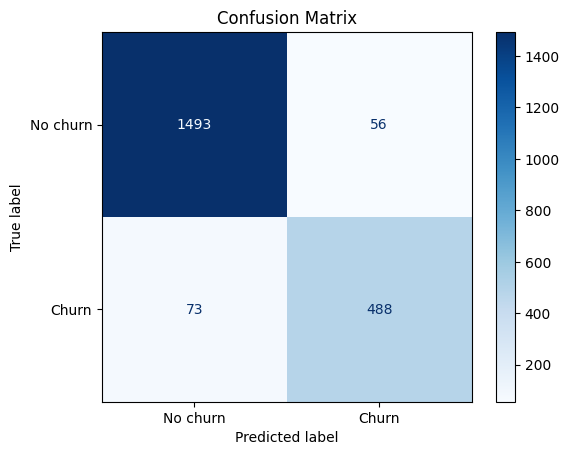

### Djupare LSTM

Den djupare modellen visade något sämre recall än basmodellen, med 484 korrekt identifierade churn-kunder och 77 missade. Även andelen falskt positiva var snarlik. Det extra LSTM-lagret verkar inte ge någon avgörande förbättring, men modellen är stabil och når ändå en hög prestanda.

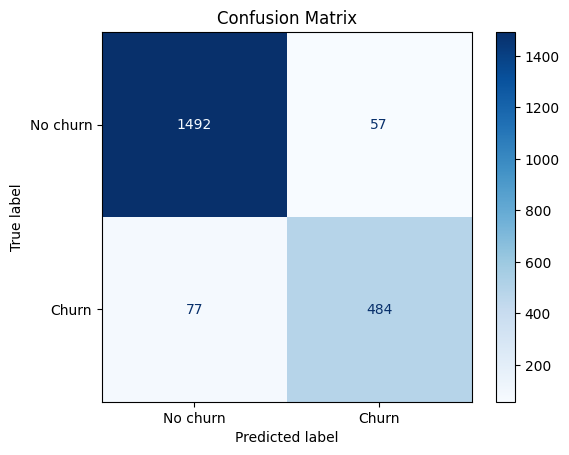

### Bidirectional LSTM

Denna modell lyckades identifiera flest churners tillsammans med TimeDistributed + L2, med 493 korrekt klassificerade och endast 68 missade. Trots något fler falskt positiva är precisionen fortfarande hög. Bidirektionalitet har här lett till förbättrad sekvensförståelse, vilket gör modellen till en av de mest träffsäkra.

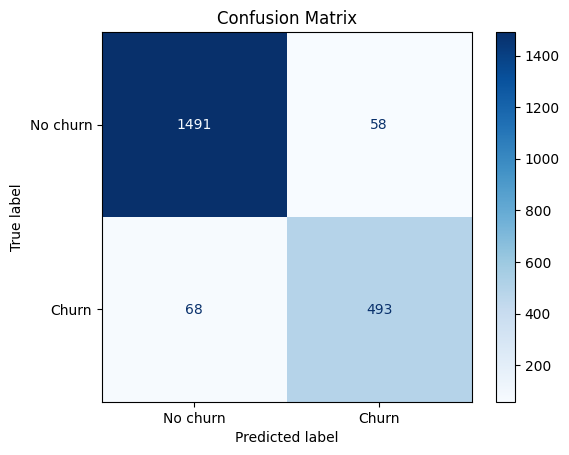

### Conv1D + LSTM

Conv1D-modellen visar en lägre prestanda än övriga toppmodeller, med 482 korrekt klassade churn-kunder och 79 missade. Den har även något fler falsklarm (62).

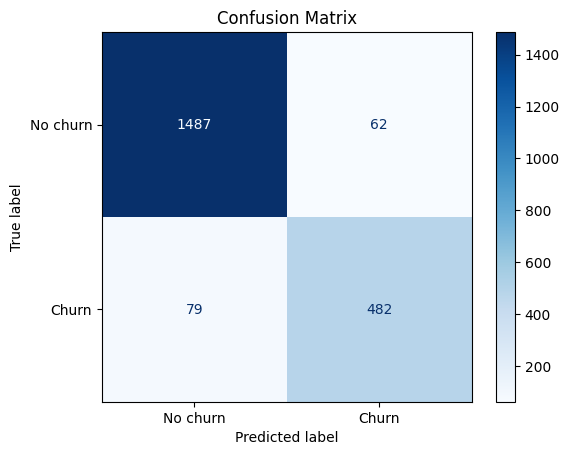

### TimeDistributed LSTM

Trots en hög generell träffsäkerhet hade modellen högst antal missade churn-kunder (91), vilket gör att recall blir lidande. Den är något sämre i sin förmåga att fånga upp churn beteende jämfört med övriga modeller. Antalet falska larm är dock fortfarande relativt lågt.

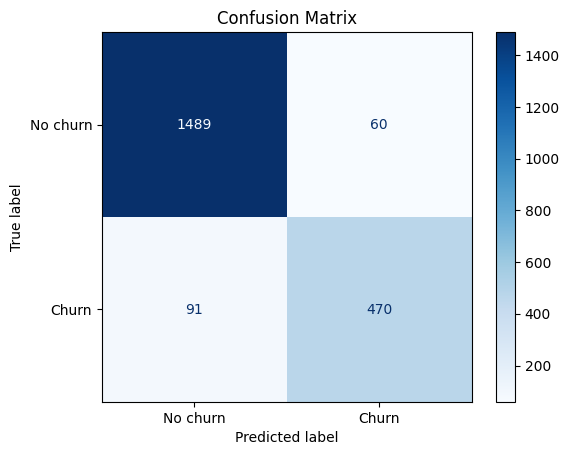

### 2x TimeDistributed LSTM

Denna modell presterar mycket bra med 490 korrekt identifierade churnkunder och endast 71 missade. Den håller både precision och recall på hög nivå, vilket gör den till en av de bättre modellerna med god generaliseringsförmåga utan regularisering (förutom 30% dropout).

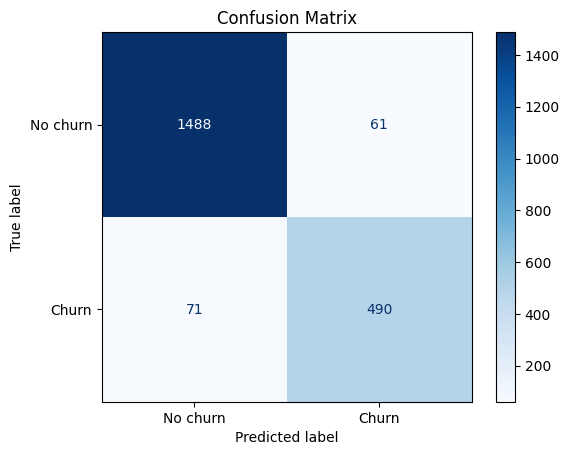

### TimeDistributed + L2-regularisering

Modellen med L2-regularisering lyckades, likt den bidirektionella, klassificerade den 493 churn-kunder korrekt och missade endast 68. Den har något fler falska positiva (65), men regulariseringen bidrar till att modellen är mindre benägen för överanpassning. Den är alltså en av de mest balanserade och robusta modellerna i jämförelsen.

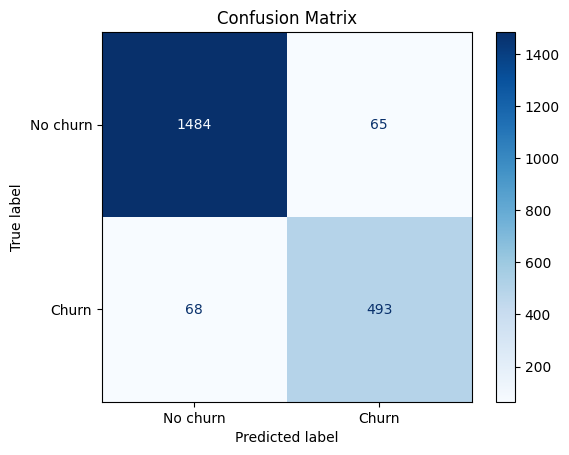

### Sammanfattning

Bidirectional LSTM och TimeDistributed + L2-regularisering var bäst på att identifiera kundbortfall. Basmodellen överraskade med väldigt få falska larm och hög precision. 2xTimeDistributed LSTM visade en stark balans utan regularisering. Vilken modell som är att föredra beror på om precision (minimera falska larm) eller recall (fånga fler churners) väger tyngst.

## Diskussion

Resultaten visar att en LSTM-modell tränad på simulerade kundsekvenser kan nå en mycket god prestanda i churprediktion. Sekventiella mönster som minskade inloggningar eller ökad supportkontakt kan fångas upp och tolkas av modellen.

Styrkor

- Även utan en direkt jämförelse mot traditionella modeller visar resultaten att tidsstrukturen i data innehåller en prediktiv signal som modellen kan lära sig från.

- Simuleringen tillåter testning utan tillgång till känslig data

- L2 regularisering och TimeDistributed gav tydliga förbättringar

Begränsningar

- Simulerad data kan inte fullt ersätta verklig data

- Parametrar och antaganden påverkar realism

- Dålig simulering av data påverkar djupinlärningsmodellerna. Data med stor skillnad i beteende mellan kundgrupper(churn/inte churn) gör det för enkelt att utföra prediktioner (100% träffsäkerhet med simpel LSTM modell). Om det är för liten skillnad i beteende mellan kundgrupperna blir det svårt att träna modeller för prediktioner. Därför behövs en balans där kundgrupperna inte är för lika eller olika varandra.

Förbättringsförslag

- Jämförelser mot verklig kunddata och kundbeteenden.

- Inkludera statiska variabler, t.ex. ålder, kön, total månadskostnad.  

Sammanfattningsvis visar detta projekt att djupinlärning i kombination med generativ simulering är en kraftfull metod för churnproblem även när verklig tidsseriedata saknas.

## Referenser

PyMC [https://www.pymc.io/]

TensorFlow Keras [https://www.tensorflow.org/guide/keras/sequential_model]

Telco Customer Churn dataset. Kaggle. [https://www.kaggle.com/blastchar/telco-customer-churn]


## GitHub-repo

Projektets kod och notebooks finns tillgängliga på GitHub https://github.com/ludwigenvall/churn-prediction-dl

Viktiga filer:

Scripts:

- generative_model.py: Bayesiansk simulering

- lstm_model.py: Funktioner för LSTM-modell

Notebooks:

- 01_explore_telco_data.ipynb: Utforskar och bearbetar data

- 02_generate_behavior.ipynb: Genererar simulerat kundbeteende och visualiserar resultaten

- 03_train_lstm_model.ipynb: Kod för att bygga, träna och utvärdera modeller